In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier

import shap
import optuna
import joblib

# Custom imports
from help_tool import help_tool, help_model

import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)

pd.set_option('future.no_silent_downcasting', True)
pd.plotting.register_matplotlib_converters()

optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme(style='whitegrid')
sns.set_palette('husl')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
selected_data = help_tool.csv_download(
    r'Archive\home-credit-default-risk\selected_data.csv').drop(columns='Unnamed: 0')

In [161]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] ==
                  selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

# Bucketing
selected_data['YEARS_BIRTH'] = help_tool.bucket_age_feature(
    selected_data, 'YEARS_BIRTH')
for feature in ['YEARS_EMPLOYED', 'AMT_CREDIT']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(
        selected_data, feature, 5)


selected_data = selected_data[selected_data['CODE_GENDER_F'].notna(
)].drop_duplicates()

# AVG Risk Score and EXT_SOURCE
AVG Risk Score is one of the beggest impactor for TARGT, same as EXT_SOURCE family. 

Notebook 4 had a feature importance check, in which top most important features were found - ['YEARS_BIRTH', 'EXT_SOURCE_2', 'CODE_GENDER_F', 'EXT_SOURCE_3']. These features were attempted to impute via LGBMRegressor and Ridge Regression. However, in previous findings it was seen that these features have no correlation, different distributions, have random places of missing values, and so building a model for imputation didn't succeed. Imputing external data would have 

As it seams like missing values are random, the next best thing is the simple impututation by mean.


In [162]:
for feature in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AVG_Risk_Score']:
    selected_data.loc[selected_data[feature].isna(
    ), feature] = selected_data[feature].mean()

In [163]:
selected_data.isna().sum()

EXT_SOURCE_1                             0
NAME_EDUCATION_TYPE                      0
AMT_CREDIT                               0
MAX(df.DURATION_DUE_VERSION)         17749
YEARS_EMPLOYED                       55373
EXT_SOURCE_3                             0
YEARS_BIRTH                              0
MAX(df.DURATION_DECISION_DRAWING)    17749
EXT_SOURCE_2                             0
MIN(df.RATIO_GOODS_PRICE_CREDIT)     17436
AVG_Risk_Score                           0
MIN(df.DURATION_DECISION_DRAWING)    17749
CODE_GENDER_F                            0
TARGET                                   0
YEARS_LAST_PHONE_CHANGE                  1
dtype: int64

# TARGET
## Dummy models for reference
Dummy model will be found via Lazypredict. But Lazypredict doesn't have build in weights. Instead, downsampled data will be provided.

In [164]:
selected_data_sample = selected_data.sample(10000, random_state=42)

X = selected_data_sample.drop('TARGET', axis=1)

y = selected_data_sample['TARGET']



# Split data into train, validation, and test sets

X_train, X_temp, y_train, y_temp, = train_test_split(

    X, y, test_size=0.3, random_state=42, stratify=y)


X_validation, X_test, y_validation, y_test, = train_test_split(

    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
classif_models, predictions = clf.fit(
    X_train, X_validation, y_train, y_validation)

100%|██████████| 29/29 [00:16<00:00,  1.77it/s]

[LightGBM] [Info] Number of positive: 538, number of negative: 6462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076857 -> initscore=-2.485836
[LightGBM] [Info] Start training from score -2.485836


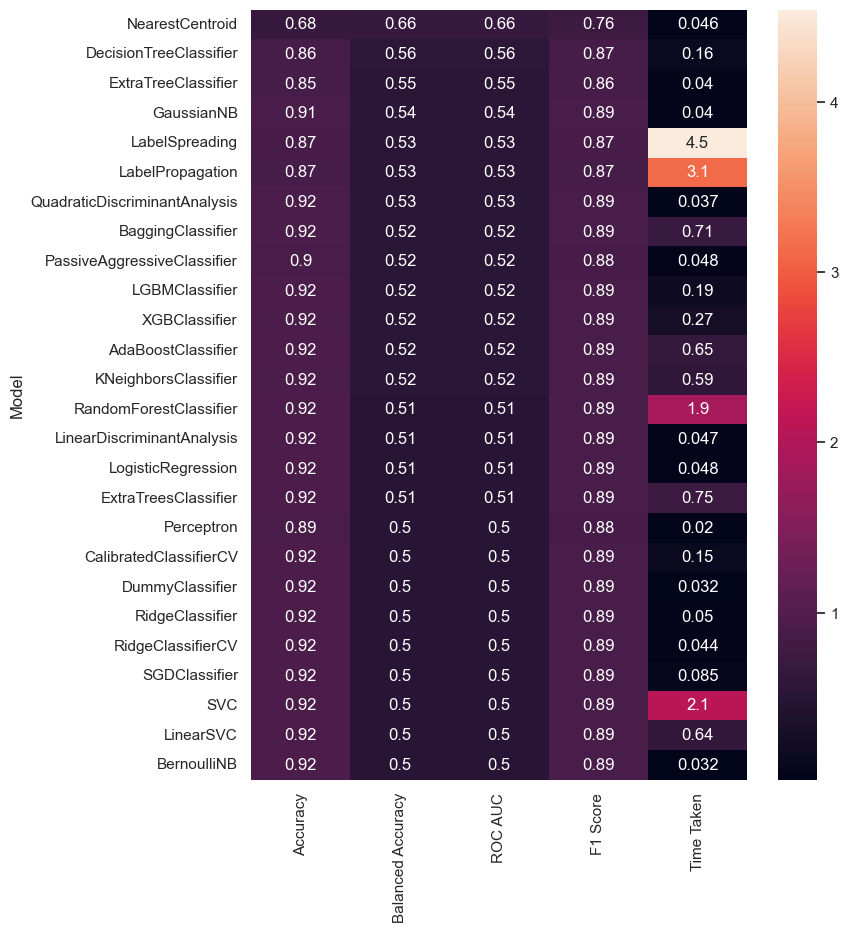

In [165]:
plt.figure(figsize=(8, 10))

sns.heatmap(classif_models[(classif_models['Time Taken'] < 5)], annot=True)
plt.show()

LGBMClassifier was chosen, as it's fast, has great performance, handles large datasets, can handle less data cleaning. The goal is to create a model with ROC AUC 0.51 or better.

Another great solution is the DecissionTree - ROC AUC of 0.54.

In [166]:
selected_data_sample = selected_data.sample(100000, random_state=42)

X = selected_data_sample.drop('TARGET', axis=1)
y = selected_data_sample['TARGET']


# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp, = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

X_validation, X_test, y_validation, y_test, = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(
    f"X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (70000, 14), y_train shape: (70000,)
X_validation shape: (20100, 14), y_validation shape: (20100,)
X_test shape: (9900, 14), y_test shape: (9900,)


# Light GBM
## Hyperparameted  Tuning
Hyperparameter search is done using Pipeline and Optuna.

In [167]:
def objective(trial, X_train, y_train):
    params = {
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-1, 5),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-1, 5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e2)
    }

    if trial.suggest_categorical('class_weight', ['balanced', None]) == 'balanced':
        params['class_weight'] = 'balanced'

    model = LGBMClassifier(**params, random_state=42, verbose=-1)

    scorer = make_scorer(f1_score)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

    mean_f1 = cv_scores.mean()
    return (1.0 - mean_f1)


study = optuna.create_study(direction='minimize')
def objective_with_data(trial): return objective(trial, X_train, y_train)



# Optimize the objective function

study.optimize(objective_with_data, n_trials=50)


print('Best trial:')

best_trial = study.best_trial

print(f'  Value (Mean F1): {1.0 - best_trial.value:.4f}')

print('  Params:')

for key, value in best_trial.params.items():

    print(f'    {key}: {value}')

Best trial:
  Value (Mean F1): 0.2693
  Params:
    lambda_l1: 0.14492794610172524
    lambda_l2: 2.838159918039739
    num_leaves: 44
    learning_rate: 0.07151597380434217
    feature_fraction: 0.400503796152356
    bagging_fraction: 0.4738125262723422
    bagging_freq: 5
    min_child_samples: 53
    min_child_weight: 0.0324552595226736
    class_weight: balanced


Parameters have been tunned - mainly reduced lambda_l1 and lambda_l2, increased num_leaves. But despite the parameter tuning, model still shows overfitting, where Training F1 score is almost 2 times higher than validation.

In [168]:
lightgbm_params = best_trial.params

lightgbm_pipeline = help_model.pipeline_creation(
    lightgbm_params, X_train, y_train, X_validation, y_validation)

F1 Score in Training: 0.3116
F1 Score in Validation: 0.2687


## Threshold Tuning
After finding the best Hyperparameters, Optimal Thresholds will be found and stored in a dataframe.

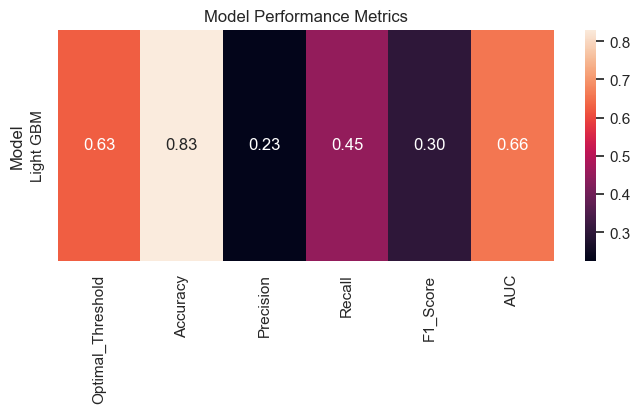

In [169]:
lightgbm_threshold = help_model.find_threshold(
    lightgbm_pipeline, X_validation, y_validation, 'Light GBM')

# Decission Tree
## Hyperparameted  Tuning
Hyperparameter search is done using Pipeline and Optuna.

In [170]:
def objective(trial, X_train, y_train):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }

    pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(**params, random_state=42))
    ])

    scorer = make_scorer(f1_score)

    cv_scores = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring=scorer)

    mean_f1 = cv_scores.mean()
    return (1.0 - mean_f1)


study = optuna.create_study(direction='minimize')
def objective_with_data(trial): return objective(trial, X_train, y_train)


# Optimize the objective function
study.optimize(objective_with_data, n_trials=50)

print('Best trial:')
best_trial = study.best_trial
print(f'  Value (Mean F1): {1.0 - best_trial.value:.4f}')
print('  Params:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value (Mean F1): 0.2343
  Params:
    criterion: gini
    splitter: random
    max_depth: 5
    min_samples_split: 4
    min_samples_leaf: 7
    max_features: None
    class_weight: balanced


In [171]:
dtree_params = best_trial.params
dtree_pipeline = help_model.pipeline_creation(
    dtree_params, X_train, y_train, X_validation, y_validation)

F1 Score in Training: 0.3049
F1 Score in Validation: 0.2647


## Threshold Tunning

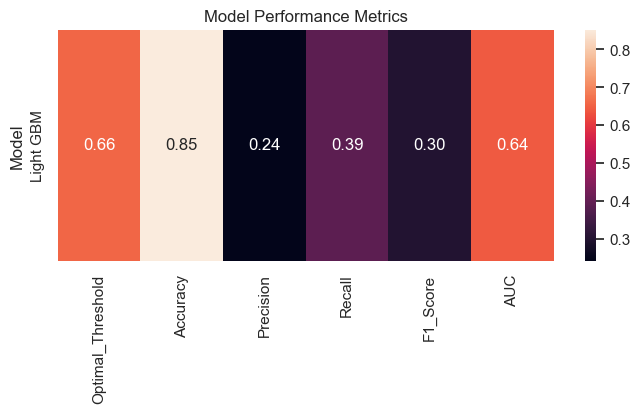

In [172]:
dtree_threshold = help_model.find_threshold(
    dtree_pipeline, X_validation, y_validation, 'Decision Tree')

# Cross Validation
Cross Validation will be performed on both of the models. Making sure the good results are not just chance.

In [173]:
classifiers = {
    'Decision Tree': dtree_pipeline,
    'LGBMClassifier': lightgbm_pipeline
}

thresholds = {
    'Decision Tree': dtree_threshold,
    'LGBMClassifier': lightgbm_threshold
}

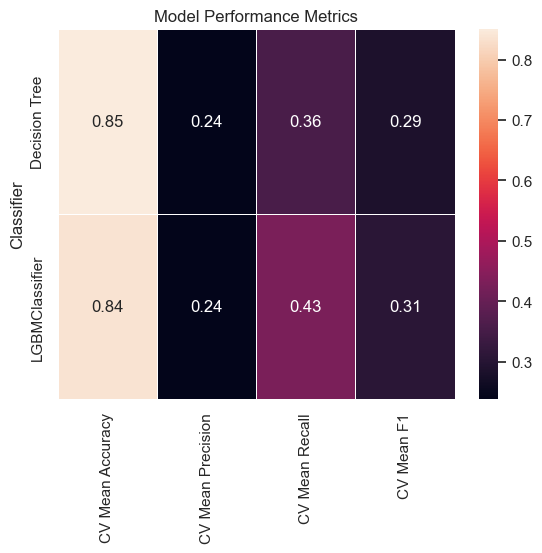

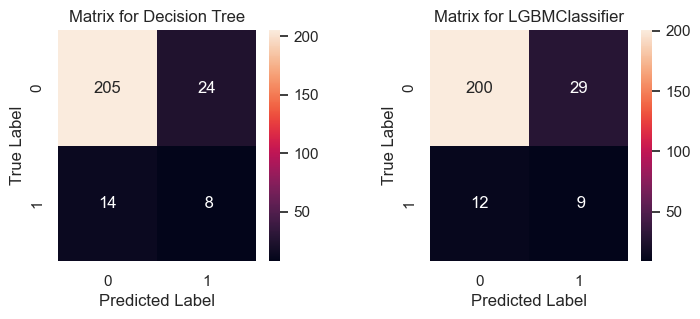

In [174]:
def cross_val_plots(fold, X, y, thresholds_df, classifiers):

    model_info = help_model.cross_val_thresholds(
        fold, X, y, thresholds_df, classifiers)

    help_tool.cross_validation_param(
        model_info.drop('Confusion Matrix', axis=1))
    help_tool.cross_validation_confusion_matrix(model_info)


cross_val_plots(20, X, y, thresholds, classifiers)

# Model explanability
LightGBM was chosen for explainability, as it had the best scores out of all of the models. Sub-sample of 100 is used instead of the whole set, for time saving.

In [175]:
background_sample = shap.sample(X_validation, 100)

classifier = lightgbm_pipeline.named_steps['classifier']


explainer = shap.Explainer(classifier)


# Calculate SHAP values

shap_values = explainer.shap_values(X_validation)

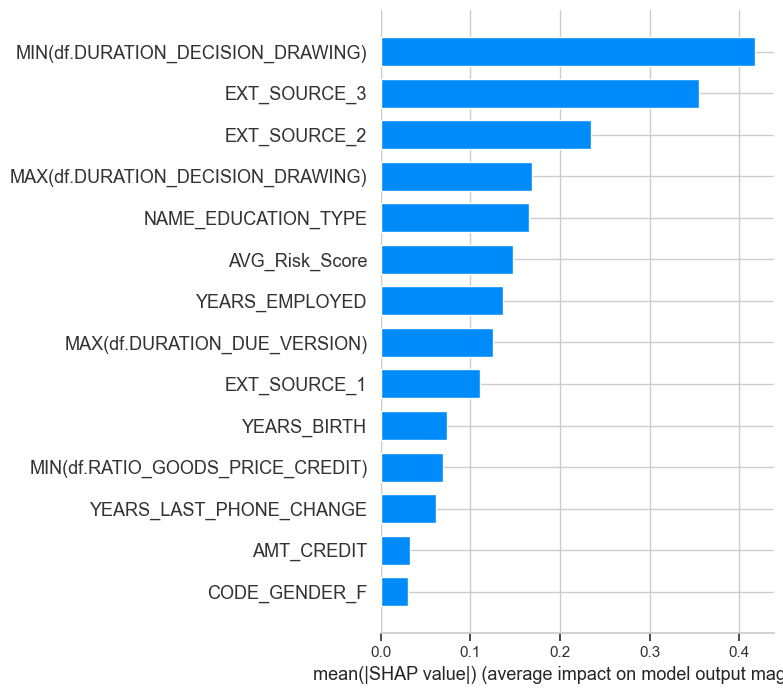

In [176]:
shap.summary_plot(shap_values, background_sample, plot_type='bar')

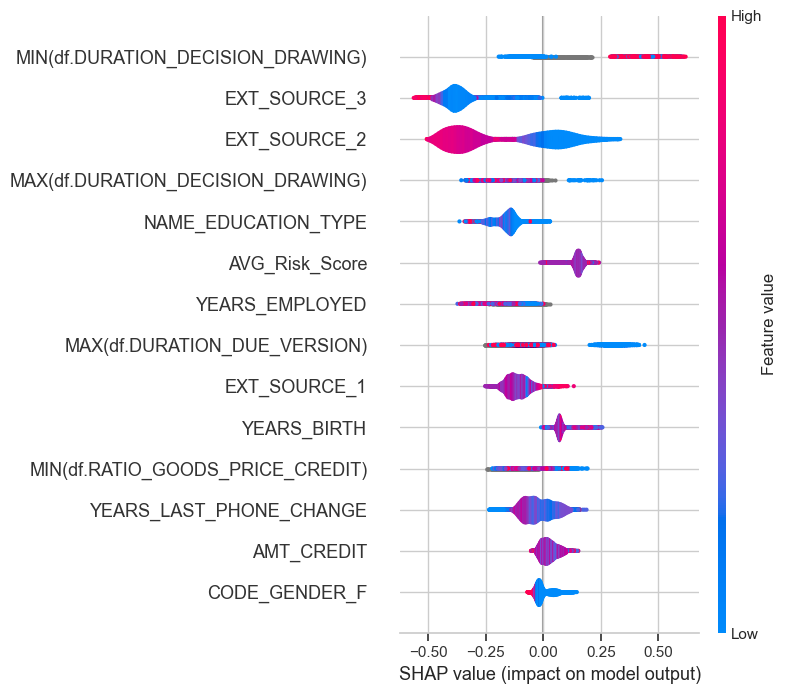

In [177]:
shap.summary_plot(shap_values, plot_type='violin', features=X_validation)

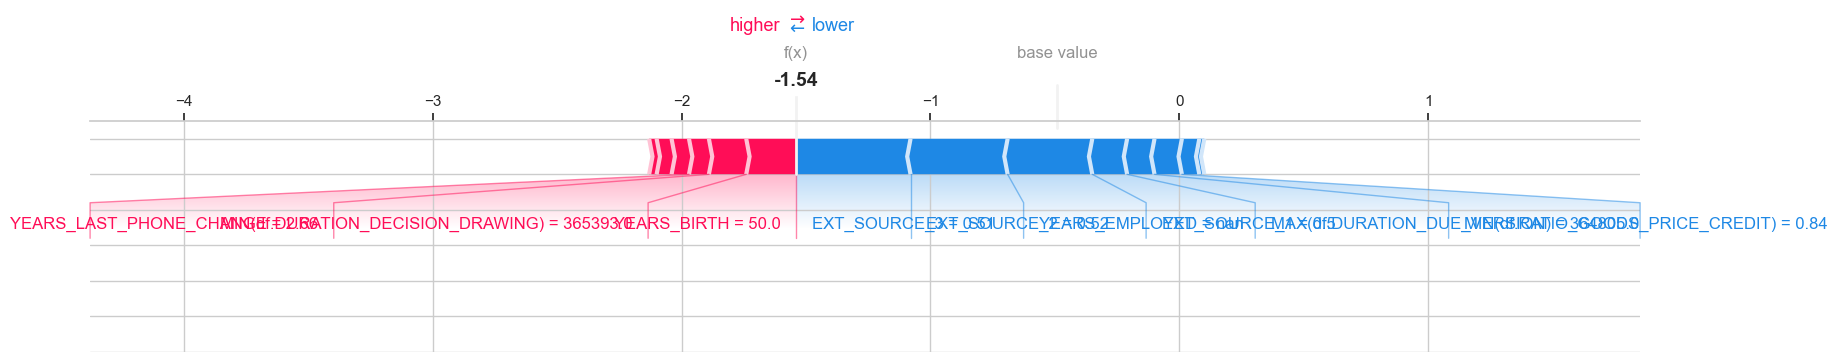

In [178]:
shap.plots.force(explainer.expected_value.round(2), shap_values[1].round(
    2), background_sample.iloc[0, :].round(2), matplotlib=True)

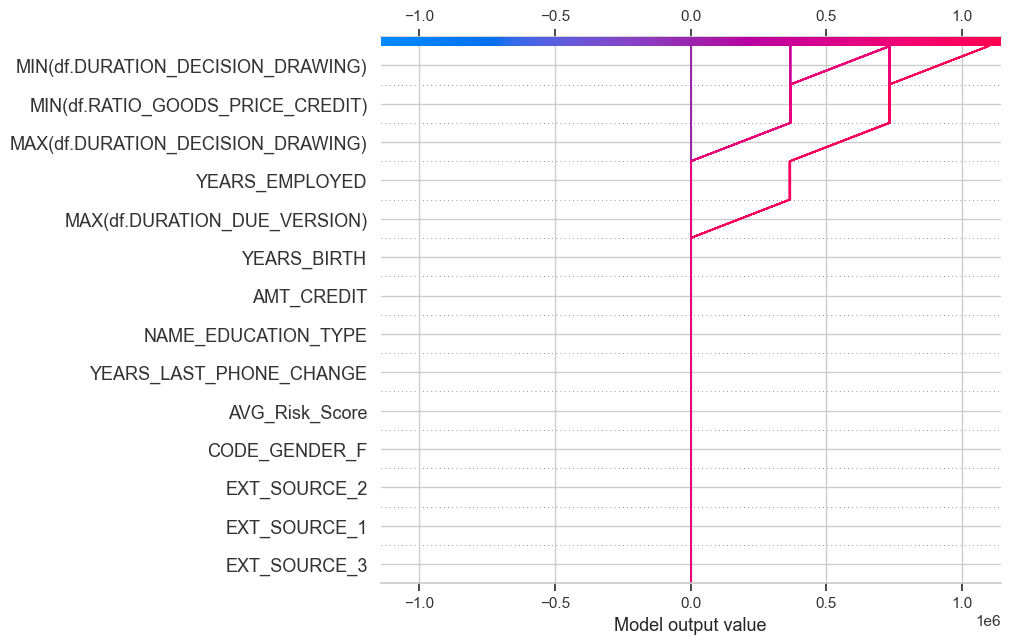

In [182]:
shap.decision_plot(explainer.expected_value, background_sample.values, background_sample.columns)

## ROC on TEST data (3rd partition)
Finally, applying the 3rd dataset (test) for finding the best model. 'Naive Bayers' is the best model for F1 and AUC scores: 0.19 and 0.72

In [186]:
def model_score_test(models, model_names, thresholds_df, X, y):
    """ Calculate various scores for multiple models"""

    data = []
    for model, label in zip(models, model_names):
        if hasattr(model, 'decision_function'):
            predictions = model.decision_function(X)
        else:
            predictions = model.predict_proba(X)[:, 1]

        optimal_threshold = thresholds_df.set_index('Model').loc[label, 'Optimal_Threshold']
        adjusted_predictions = (predictions > optimal_threshold).astype(int)

        f1 = f1_score(y, adjusted_predictions)
        accuracy = accuracy_score(y, adjusted_predictions)
        precision = precision_score(y, adjusted_predictions)
        recall = recall_score(y, adjusted_predictions)
        auc = roc_auc_score(y, predictions)

        data.append([label, accuracy, precision, recall, f1, auc])

    columns = ["Classifier", "Accuracy", "Precision", "Recall", "F1", "AUC"]
    return pd.DataFrame(data, columns=columns)

In [187]:
thresholds_df = pd.concat(
    [thresholds['Decision Tree'], thresholds['LGBMClassifier']], axis=0)

models = [classifiers['Decision Tree'], classifiers['LGBMClassifier']]
model_name = thresholds_df['Model'].to_list()


metric_scores = model_score_test(
    models, model_name, thresholds_df, X_test, y_test)
help_tool.cross_validation_param(metric_scores)

ValueError: ('Lengths must match to compare', (2,), (9900,))

In [210]:
pd.DataFrame(thresholds['Decision Tree']).dtype

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [211]:
classifiers

{'Decision Tree': Pipeline(steps=[('scaler', StandardScaler()),
                 ('classifier',
                  LGBMClassifier(class_weight='balanced', criterion='gini',
                                 max_depth=5, max_features=None,
                                 min_samples_leaf=7, min_samples_split=4,
                                 splitter='random', verbose=-1))]),
 'LGBMClassifier': Pipeline(steps=[('scaler', StandardScaler()),
                 ('classifier',
                  LGBMClassifier(bagging_fraction=0.4738125262723422,
                                 bagging_freq=5, class_weight='balanced',
                                 feature_fraction=0.400503796152356,
                                 lambda_l1=0.14492794610172524,
                                 lambda_l2=2.838159918039739,
                                 learning_rate=0.07151597380434217,
                                 min_child_samples=53,
                                 min_child_weight=0.0324552595

In [212]:
thresholds

{'Decision Tree':        Model  Optimal_Threshold  Accuracy  Precision  Recall  F1_Score  AUC
 0  Light GBM               0.66      0.85       0.24    0.39      0.30 0.64,
 'LGBMClassifier':        Model  Optimal_Threshold  Accuracy  Precision  Recall  F1_Score  AUC
 0  Light GBM               0.63      0.83       0.23    0.45      0.30 0.66}

In [208]:
pd.DataFrame(thresholds['Decision Tree']).rename({'Light GBM': 'Decision Tree'})

,Model,Optimal_Threshold,Accuracy,Precision,Recall,F1_Score,AUC
0,Light GBM,0.66,0.85,0.24,0.39,0.30,0.64


In [226]:
pd.concat([thresholds['Decision Tree'].rename({'Light GBM': 'Decision Tree'}), thresholds['LGBMClassifier']], axis=0)

,Model,Optimal_Threshold,Accuracy,Precision,Recall,F1_Score,AUC
0,Light GBM,0.66,0.85,0.24,0.39,0.30,0.64
0,Light GBM,0.63,0.83,0.23,0.45,0.30,0.66


In [225]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def model_score_test(models, model_names, thresholds_df, X, y):
    """ Calculate various scores for multiple models"""

    data = []
    for model, label in zip(models, model_names):
        if hasattr(model, 'decision_function'):
            predictions = model.decision_function(X)
        else:
            predictions = model.predict_proba(X)[:, 1]

        optimal_threshold = thresholds_df.set_index('Model').loc[label, 'Optimal_Threshold']
        adjusted_predictions = (predictions > optimal_threshold).astype(int)

        f1 = f1_score(y, adjusted_predictions)
        accuracy = accuracy_score(y, adjusted_predictions)
        precision = precision_score(y, adjusted_predictions)
        recall = recall_score(y, adjusted_predictions)
        auc = roc_auc_score(y, predictions)

        data.append([label, accuracy, precision, recall, f1, auc])

    columns = ["Classifier", "Accuracy", "Precision", "Recall", "F1", "AUC"]
    return pd.DataFrame(data, columns=columns)

# Assuming thresholds_df is correctly defined earlier
thresholds_df = pd.concat([thresholds['Decision Tree'], thresholds['LGBMClassifier']], axis=0)

models = [classifiers['Decision Tree'], classifiers['LGBMClassifier']]
model_names = thresholds_df['Model'].tolist()  # Corrected


metric_scores = model_score_test(models, model_names, thresholds_df, X_test, y_test)
help_tool.cross_validation_param(metric_scores)  # Assuming cross_validation_param is defined in help_tool


ValueError: ('Lengths must match to compare', (2,), (9900,))

Saving Best Model to pickle file. Threshold will be added manualy.

In [223]:
thresholds['LGBMClassifier']['Optimal_Threshold']

0   0.63
Name: Optimal_Threshold, dtype: float64

In [224]:
# Save model as pickle file
joblib.dump(classifiers['LGBMClassifier'], "model.pkl")

thresholds['LGBMClassifier']['Optimal_Threshold']

0   0.63
Name: Optimal_Threshold, dtype: float64

# Conclusion

